# About

This notebook replicates the demonstration of the evomap package in the paper:

Matthe, Maximilian (2023), "evomap: A Python Package for Dynamic Mapping". 

Python environment: evomap-package

For details on the used package versions, see the file evomap-package-environment.yml

All code was run on MacOS 13.4.1.

# Setup

First, create path variabels for each subfolder and import the essential packages.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

PATH_HOME = os.path.dirname(os.getcwd()) # parent folder
PATH_OUT = os.path.join(PATH_HOME, 'gen') # output folder
PATH_DATA = os.path.join(PATH_HOME, 'data') # input folder

# Plotting parameters
title_fontdict = {'size': 12, 'family': 'Arial'}
title_fontdict_large = {'size': 16, 'family': 'Arial'}
label_fontdict = {'size': 10, 'family': 'Arial'}
label_fontdict_large = {'size': 14, 'family': 'Arial'}

# Set random seed for reproducibility
np.random.seed(111)

# Part 1: Quick Illustration

This first part provides a quick illustration of how EvoMap can be applied using the evomap package. It also highlights the differences between applying EvoMap vs. applying existent static mapping methods.

The following code displays the necessary steps to generate the output shown in section 2 of the paper ('background on mapping'). 

## Loading the Data

For most of this illustration, we use a small sample from the TNIC data available through the dataset submodule.

In [2]:
from evomap.datasets import load_tnic_sample_tech

data = load_tnic_sample_tech()

In [3]:
data.head()

,year,name1,name2,score,sic1,sic2,size1,size2,gvkey1,gvkey2
0,1998,APPLE INC,WESTERN DIGITAL CORP,0.0657,36,35,71.792988,32.294908,1690,11399
1,1998,APPLE INC,MICROSOFT CORP,0.0601,36,73,71.792988,517.384045,1690,12141
2,1998,APPLE INC,ORACLE CORP,0.0355,36,73,71.792988,188.441005,1690,12142
3,1998,AT&T INC,US CELLULAR CORP,0.0761,48,48,324.142356,57.620292,9899,14369
4,1998,EBAY INC,MICROSOFT CORP,0.0281,73,73,98.544590,517.384045,114524,12141


In [4]:
data.tail()

,year,name1,name2,score,sic1,sic2,size1,size2,gvkey1,gvkey2
437,2017,ORACLE CORP,MICROSOFT CORP,0.1292,73,73,432.134053,728.911819,12142,12141
438,2017,ORACLE CORP,INTUIT INC,0.0231,73,73,432.134053,187.297107,12142,27928
439,2017,US CELLULAR CORP,AT&T INC,0.0184,48,48,56.555725,488.570204,14369,9899
440,2017,WESTERN DIGITAL CORP,APPLE INC,0.0321,35,36,161.395167,888.847624,11399,1690
441,2017,WESTERN DIGITAL CORP,MICRON TECHNOLOGY INC,0.0788,35,36,161.395167,188.548774,11399,7343


The sample is organized as an edgelist where each observation corresponds to a single firm-firm pair. It contains a total of 9 firms and their pairiwse relationships over 20 years.

In [5]:
data.groupby('name1').agg({'year':'nunique'})

,year
name1,
APPLE INC,20
AT&T INC,20
EBAY INC,20
INTUIT INC,20
MICRON TECHNOLOGY INC,20
MICROSOFT CORP,20
ORACLE CORP,20
US CELLULAR CORP,20
WESTERN DIGITAL CORP,20


In [6]:
table_overview = pd.concat([data.head(), data.tail()], axis = 0)
table_overview = table_overview[['year', 'name1', 'name2', 'score', 'sic1', 'sic2', 'size1', 'size2']]
table_overview.size1 = table_overview.size1.round(2)
table_overview.size2 = table_overview.size2.round(2)
table_overview

,year,name1,name2,score,sic1,sic2,size1,size2
0,1998,APPLE INC,WESTERN DIGITAL CORP,0.0657,36,35,71.79,32.29
1,1998,APPLE INC,MICROSOFT CORP,0.0601,36,73,71.79,517.38
2,1998,APPLE INC,ORACLE CORP,0.0355,36,73,71.79,188.44
3,1998,AT&T INC,US CELLULAR CORP,0.0761,48,48,324.14,57.62
4,1998,EBAY INC,MICROSOFT CORP,0.0281,73,73,98.54,517.38
437,2017,ORACLE CORP,MICROSOFT CORP,0.1292,73,73,432.13,728.91
438,2017,ORACLE CORP,INTUIT INC,0.0231,73,73,432.13,187.30
439,2017,US CELLULAR CORP,AT&T INC,0.0184,48,48,56.56,488.57
440,2017,WESTERN DIGITAL CORP,APPLE INC,0.0321,35,36,161.40,888.85
441,2017,WESTERN DIGITAL CORP,MICRON TECHNOLOGY INC,0.0788,35,36,161.40,188.55


Save this overview as Table 2 in the paper.

In [7]:
table_overview.to_excel(os.path.join(PATH_OUT, "table2-data-overview.xlsx"))

Next, transform the edgelist into a sequence of similarity matrices

In [8]:
from evomap.preprocessing import edgelist2matrices
S_t, labels_t = edgelist2matrices(
    data, 
    score_var = 'score', 
    id_var_i = 'name1', 
    id_var_j = 'name2', 
    time_var = 'year')

The result is a sequence of matrices and a sequence of labels. As the sample is balanced, all labels remain the same over time in this example. Therefore, we simply use the first list of labels in what follows. 

In [9]:
labels = labels_t[0]
labels

array(['APPLE INC', 'AT&T INC', 'EBAY INC', 'INTUIT INC',
       'MICRON TECHNOLOGY INC', 'MICROSOFT CORP', 'ORACLE CORP',
       'US CELLULAR CORP', 'WESTERN DIGITAL CORP'], dtype='<U21')

Preview a single similarity matrix.

In [10]:
S_t[0].round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.04, 0.  , 0.07],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  ],
       [0.  , 0.  , 0.  , 0.09, 0.  , 0.03, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.09, 0.  , 0.  , 0.05, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03],
       [0.06, 0.  , 0.03, 0.05, 0.  , 0.  , 0.1 , 0.  , 0.03],
       [0.04, 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.  , 0.03],
       [0.  , 0.08, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.07, 0.  , 0.  , 0.  , 0.03, 0.03, 0.03, 0.  , 0.  ]])

To map this similarity matrix via MDS, first transform it into dissimilarities using the sim2diss function from the preprocessing submodule.

In [11]:
from evomap.preprocessing import sim2diss
D_t = []
for S in S_t:
    D_t.append(sim2diss(S, transformation = 'mirror'))

Preview a single dissimilarity matrix

In [12]:
D_t[0].shape

(9, 9)

In [13]:
D_t[0].shape

(9, 9)

## Static Mapping via MDS

First, we create static snapshots of these matrices using MDS. 

In [14]:
periods = data.year.unique()
n_periods = len(periods)
n_samples = len(labels)

In [15]:
print("First snapshot corresponds to the year {0}".format(periods[0]))

First snapshot corresponds to the year 1998


In [16]:
D_0 = D_t[0]

Here, we use non-metric ordinal MDS, initialized via Classical Scaling. 

In [17]:
from evomap.mapping import MDS
mds = MDS(mds_type = 'ordinal', init = 'cmds')
X_0 = mds.fit_transform(D_0)

To display the results, first draw a single snapshot.

In [18]:
from matplotlib import pyplot as plt
from evomap.printer import draw_map

fig, ax = plt.subplots(1,2, figsize = (12,6))
draw_map(
    X_0, 
    label = labels, 
    show_axes = True, 
    axes_at_origin = False, 
    show_grid = False, 
    ax = ax[0])

ax[0].set_title('A: Static MDS Map \n', fontdict= title_fontdict_large)


Text(0.5, 1.0, 'A: Static MDS Map \n')

Next, add the Shepard diagram to evaluate the snapshot's mapping quality. 

In [19]:
from evomap.printer import draw_shepard_diagram
    
draw_shepard_diagram(X_0, D_0, ax = ax[1])
ax[1].set_title('B: Shepard Diagram \n', fontdict= title_fontdict_large)
ax[1].legend(['Observed dissimilarities', 'Transformed dissimilariites'], loc = 4, prop = label_fontdict)

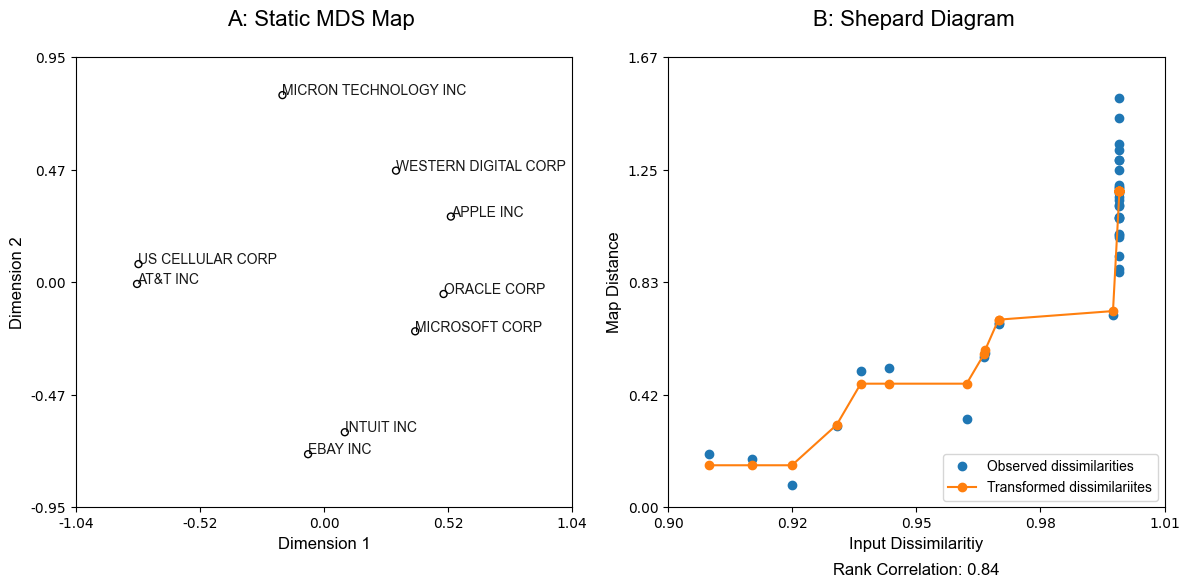

In [20]:
fig.tight_layout()
fig

In [21]:
print("Final Stress value: {0:.2f}".format(mds.cost_))

Final Stress value: 0.14


Save the Figure as Figure 1 of the Paper.

In [22]:
fig.savefig(os.path.join(PATH_OUT, 'sect1_mds_statc.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect1_mds_statc.svg'), dpi = 1200)

## Dynamic Mapping via EvoMap

To illustrate Dynamic Mapping, we apply EvoMap, implemented for MDS, to the entire sequence of matrices. 

We generate two benchmarks: 
- A sequence of misaligned maps using EvoMap with alpha = 0 (corresponding to independent application of static MDS) 
- A sequence of aligned maps using EvoMap with alpha > 0 

First, generate a sequence of starting configurations using the Classical Scaling solution as before.

In [23]:
from evomap.mapping import MDS
X_t_indep = []
costs_indep = []
for D in D_t:
    mds = MDS(mds_type = 'ordinal', init = 'cmds')
    X = mds.fit_transform(D)
    X_t_indep.append(X)
    costs_indep.append(mds.cost_)

Further, we try to align the independently created configurations as best using static MDS by using a constant starting initialization and applying Procrustes Analysis to the resultant sequence. 

To do so, |first create a sequence of starting configurations.

In [24]:
from evomap.mapping import CMDS
cmds_t = []
cmds = CMDS().fit_transform(D_t[0])
for t in range(n_periods):
    cmds_t.append(cmds)

Then, apply EvoMDS using alpha = 0 and align the sequence ex post.

In [25]:
from evomap.mapping import EvoMDS
from evomap.transform import align_maps
evomds_indep_aligned = EvoMDS(alpha = 0, mds_type = 'ordinal', init = cmds_t)
X_t_indep_aligned = evomds_indep_aligned.fit_transform(D_t)
X_t_indep_aligned = align_maps(X_t_indep_aligned, X_t_indep_aligned[0])

For comparison, use EvoMap with a positive value of alpha and add some smoothing by increasing p to 2:

In [26]:
evomds = EvoMDS(alpha = .2, p = 2, mds_type = 'ordinal', init = cmds_t)
X_t = evomds.fit_transform(D_t) 

 Show all results side by side:


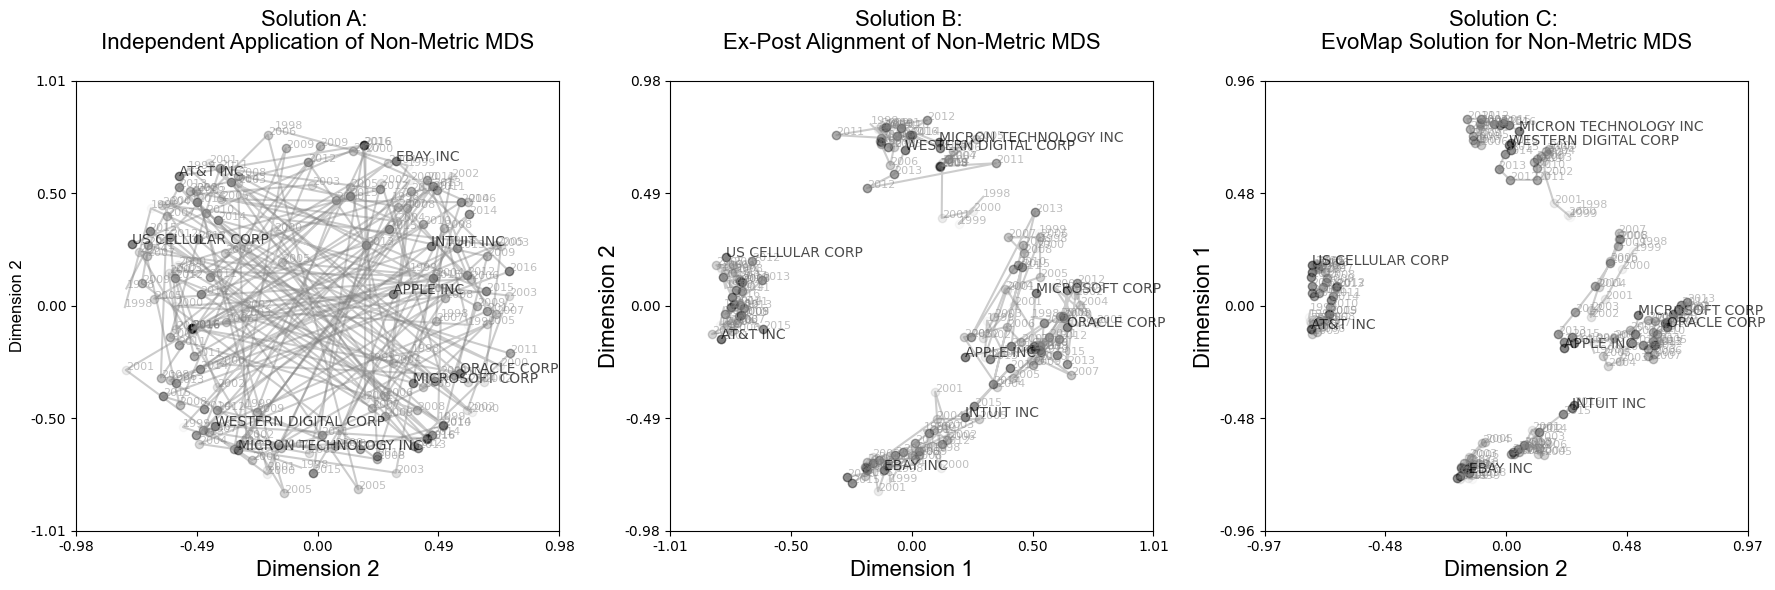

In [27]:
from evomap.printer import draw_trajectories
fig, ax = plt.subplots(1,3,figsize = (18,6))
draw_trajectories(X_t_indep, show_axes= True, labels = labels, period_labels= periods, ax = ax[0])
draw_trajectories(X_t_indep_aligned, labels = labels, period_labels= periods, show_axes = True, ax = ax[1])
draw_trajectories(X_t, labels = labels, period_labels= periods, show_axes = True, ax = ax[2])

ax[0].set_title('Solution A: \nIndependent Application of Non-Metric MDS\n', fontdict = title_fontdict_large)
ax[1].set_title('Solution B: \nEx-Post Alignment of Non-Metric MDS\n', fontdict = title_fontdict_large)
ax[2].set_title('Solution C: \nEvoMap Solution for Non-Metric MDS\n', fontdict = title_fontdict_large)

ax[0].set_xlabel("Dimension 1", fontdict = title_fontdict_large)
ax[1].set_xlabel("Dimension 1", fontdict = title_fontdict_large)
ax[2].set_ylabel("Dimension 1", fontdict = title_fontdict_large)
ax[0].set_xlabel("Dimension 2", fontdict = title_fontdict_large)
ax[1].set_ylabel("Dimension 2", fontdict = title_fontdict_large)
ax[2].set_xlabel("Dimension 2", fontdict = title_fontdict_large)

fig.tight_layout()
fig

In [28]:
print("The maps represent the evolving positions over {0} years between {1} and {2}".format(n_periods, periods[0], periods[-1]))

The maps represent the evolving positions over 20 years between 1998 and 2017


Save the Figure as Figure 2 in the paper.

In [29]:
fig.savefig(os.path.join(PATH_OUT, 'sect1_mds_dynamic.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect1_mds_dynamic.svg'), dpi = 1200)

# Part 2: Step by Step Instructions

This part goes through each step performed above in more details. The following sections provide more details about each step, showcases available options, and illustrates their respective impact.  

The basic syntax to use evomap consists of the following lines of code, which instantinates the method and fits it to the data. Note that the import statement is not necessary here, as we imported the class before, but only included for completeness of this minimal example. 

In [30]:
from evomap.mapping import EvoMDS
evomds = EvoMDS()
X_t = evomds.fit_transform(D_t) 

The output is a list of arrays shape (n_samples, n_dims)

In [31]:
print(type(X_t))

<class 'list'>


In [32]:
print(len(X_t))

20


In [33]:
print(X_t[0].round(2))

[[ 0.01  0.63]
 [ 0.65  0.01]
 [-0.51 -0.51]
 [-0.18 -0.16]
 [ 0.07 -0.72]
 [ 0.39 -0.35]
 [-0.43  0.48]
 [-0.71  0.05]
 [ 0.4   0.44]]


Naturally, the resultant configurations will not be aligned. Instead, they correspond to the results of independently applying MDS at each point in time. 

Better results: Set alpha to higher levels. In addition, we specify the type of MDS method used (here: ordinal MDS), and set a higher level of verbosity to obtain more diagnostics. 

In [34]:
from evomap.mapping import EvoMDS

evomds = EvoMDS(
    alpha = .2, 
    mds_type = 'ordinal', 
    verbose=2)

X_t = evomds.fit_transform(D_t) 

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 6.06 -- Gradient Norm: 0.1717
[EvoMDS] Iteration 100 -- Cost: 5.10 -- Gradient Norm: 0.0753
[EvoMDS] Iteration 150 -- Cost: 4.83 -- Gradient Norm: 0.0542
[EvoMDS] Iteration 200 -- Cost: 4.34 -- Gradient Norm: 0.0613
[EvoMDS] Iteration 250 -- Cost: 4.28 -- Gradient Norm: 0.0239
[EvoMDS] Iteration 300 -- Cost: 4.16 -- Gradient Norm: 0.0322
[EvoMDS] Iteration 350 -- Cost: 3.78 -- Gradient Norm: 0.0185
[EvoMDS] Iteration 351: gradient norm vanished. Final cost: 3.78


First snapshot

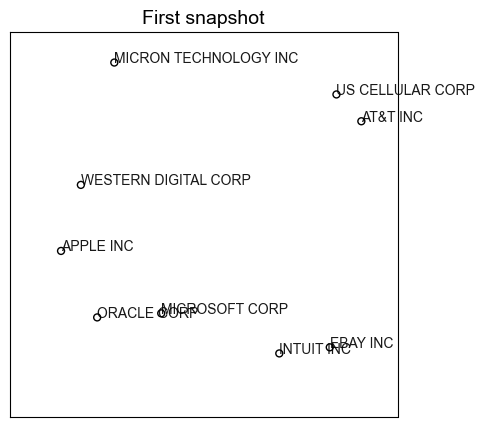

In [35]:
draw_map(X_t[0], label = labels, title = 'First snapshot')

Last snapshot

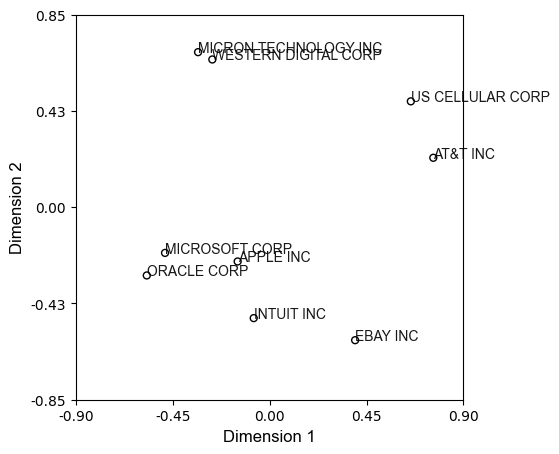

In [36]:
draw_map(X_t[-1], label = labels, show_axes = True)

Side by side comparison

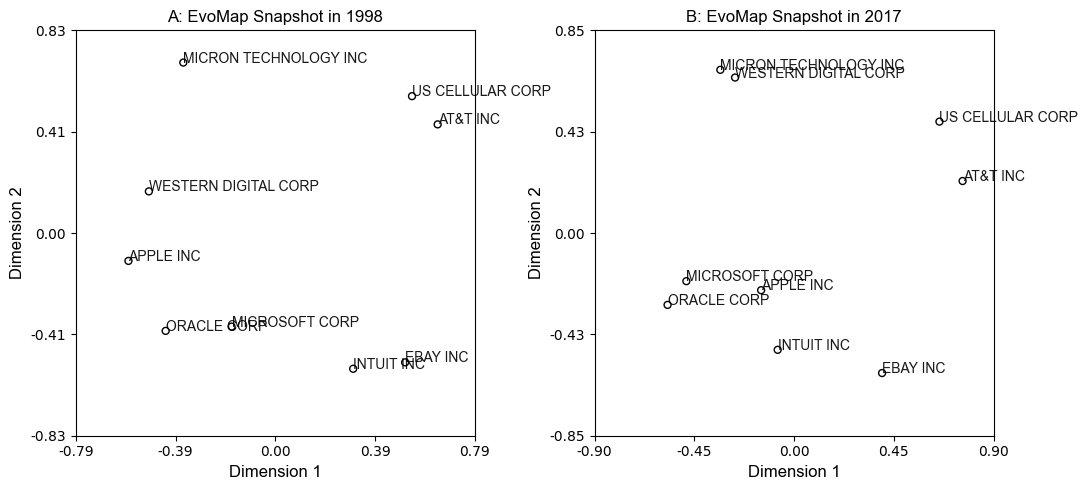

In [37]:
from evomap.printer import draw_map
fig, ax = plt.subplots(1,2,figsize = (11,5))

draw_map(X_t[0], label = labels, ax = ax[0], show_axes = True)
draw_map(X_t[-1], label = labels, ax = ax[1], show_axes = True)
ax[0].set_title('A: EvoMap Snapshot in {0}'.format(periods[0]), fontdict = title_fontdict)
ax[1].set_title('B: EvoMap Snapshot in {0}'.format(periods[-1]), fontdict = title_fontdict)
#fig.tight_layout()
fig.tight_layout()
fig.subplots_adjust(wspace = .3)
fig.savefig(os.path.join(PATH_OUT, 'sect4_evomds_snapshots.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect4_evomds_snapshots.svg'), dpi = 1200)

fig

Result: Much better alignment! 

## Fixing the starting configuration

Thus far, initialized randomly. If one of the cell is run again, output will differ. To change that: Set a fixed init. 

One way to fix the starting configuration is to manually calculate random numbers. Another, especially suitable for MDS variants, is to use the classical scaling solution as a starting point for the optimization:

In [38]:
from evomap.mapping import CMDS
cmds_t = []
cmds = CMDS().fit_transform(D_t[0])
for t in range(n_periods):
    cmds_t.append(cmds)

In [39]:
evomds_cmds = EvoMDS(alpha = .2, mds_type = 'ordinal', init = cmds_t, verbose = 2)
X_t_cmds = evomds_cmds.fit_transform(D_t) 

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 3.80 -- Gradient Norm: 0.0283
[EvoMDS] Iteration 100 -- Cost: 3.80 -- Gradient Norm: 0.0012
[EvoMDS] Iteration 105: gradient norm vanished. Final cost: 3.80


In [40]:
print("Final cost when initialized with Classical Scaling: {0:.3f}".format(evomds_cmds.cost_))

Final cost when initialized with Classical Scaling: 3.798


In [41]:
evomds_cmds.cost_static_avg_.round(4)

0.1877

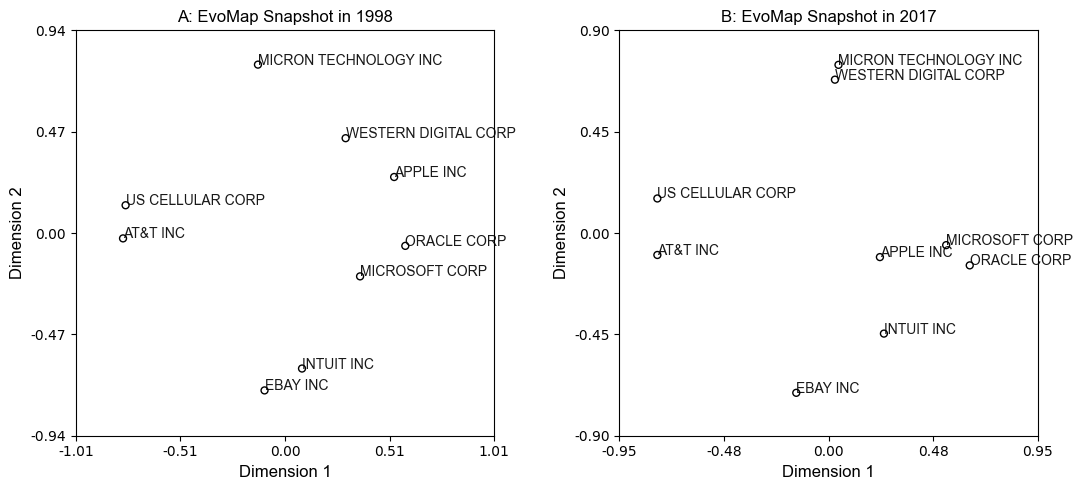

In [42]:
from evomap.printer import draw_map
fig, ax = plt.subplots(1,2,figsize = (11,5))

draw_map(X_t_cmds[0], label = labels, ax = ax[0], show_axes = True)
draw_map(X_t_cmds[-1], label = labels, ax = ax[1], show_axes = True)
ax[0].set_title('A: EvoMap Snapshot in {0}'.format(periods[0]), fontdict = title_fontdict)
ax[1].set_title('B: EvoMap Snapshot in {0}'.format(periods[-1]), fontdict = title_fontdict)
#fig.tight_layout()
fig.tight_layout()
fig.subplots_adjust(wspace = .3)
fig.savefig(os.path.join(PATH_OUT, 'sect4_evomds_cmds_snapshots.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect4_evomds_cmds_snapshots.svg'), dpi = 1200)
fig

In [43]:
X_t = X_t_cmds

## Adjusting the Level of Verbosity

In [44]:
EvoMDS(
    alpha = .25, 
    mds_type = 'ordinal', 
    init = cmds_t,
    verbose = 0).fit(D_t)

In [45]:
EvoMDS(
    alpha = .25, 
    mds_type = 'ordinal', 
    init = cmds_t,
    verbose = 1).fit(D_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 88: gradient norm vanished. Final cost: 3.82


In [46]:
EvoMDS(
    alpha = .2, 
    mds_type = 'ordinal', 
    init = cmds_t,
    n_iter_check = 20,
    verbose = 2).fit(D_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 20 -- Cost: 3.81 -- Gradient Norm: 0.0245
[EvoMDS] Iteration 40 -- Cost: 3.80 -- Gradient Norm: 0.0104
[EvoMDS] Iteration 60 -- Cost: 3.80 -- Gradient Norm: 0.0076
[EvoMDS] Iteration 80 -- Cost: 3.80 -- Gradient Norm: 0.0058
[EvoMDS] Iteration 100 -- Cost: 3.80 -- Gradient Norm: 0.0012
[EvoMDS] Iteration 105: gradient norm vanished. Final cost: 3.80


## Exploration

#### Static Exploration via Draw Map

First, store some additional to augment the maps with.

SIC codes are categorical industry codes:

In [47]:
sic_codes = []
for firm in labels:
    sic_codes.append(data.query('name1 == @firm').sic1.unique()[0])
print(sic_codes)

[36, 48, 73, 73, 36, 73, 73, 48, 35]


Note that as data is sorted by years, the above code returns the SIC codes at the first availabel period. 

Size is a variable proportional to market value:

In [48]:
sizes = []
for firm in labels:
    sizes.append(data.query('name1 == @firm').size1.unique()[0].round(2))
print(sizes)

[71.79, 324.14, 98.54, 54.32, 69.69, 517.38, 188.44, 57.62, 32.29]


Such variables can be added to the map via the 'c' and 'size' arguments:

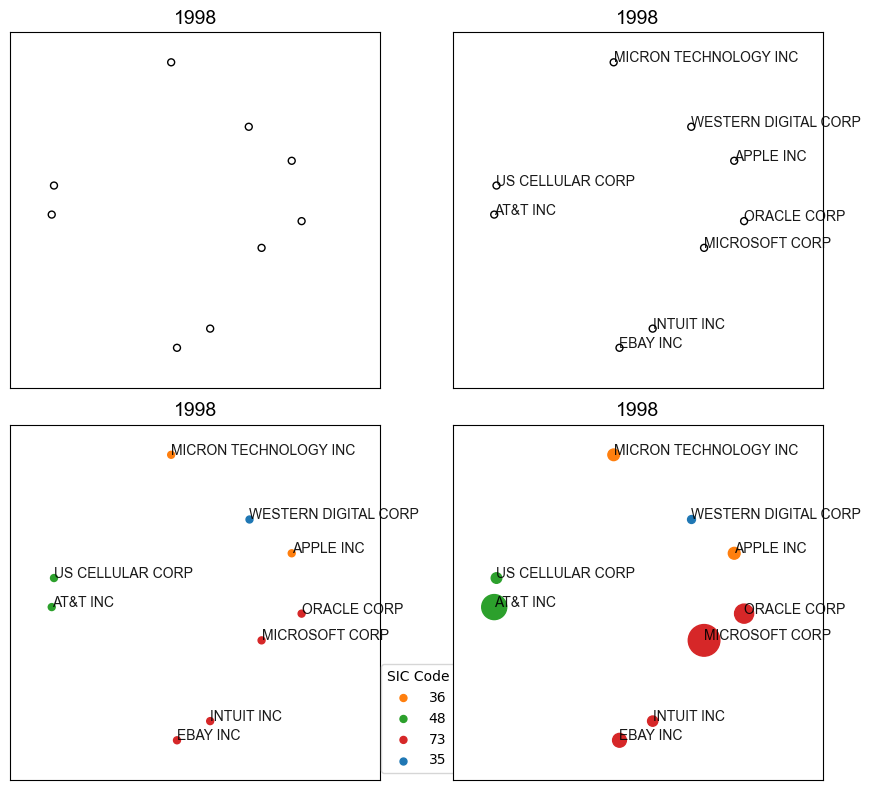

In [49]:
sic = data.sic1

fig, ax = plt.subplots(2,2,figsize = (9,8))
draw_map(X_t[0], title = periods[0], ax = ax[0,0])
draw_map(X_t[0], label = labels, title = periods[0], ax = ax[0,1])
draw_map(X_t[0], label = labels, color = sic_codes, show_legend = False, title = periods[0], ax = ax[1,0])
draw_map(X_t[0], label = labels, color = sic_codes, size = sizes, 
title = periods[0], ax = ax[1,1])
fig.tight_layout()

ax[1,0].legend(title = 'SIC Code', loc = 'lower right', bbox_to_anchor = (1.22, 0.0))
#lgnd = ax[1,1].legend(title = 'SIC Code', loc = 'lower left')
#for handle in lgnd.legend_handles:
#    handle.set_sizes([25.0])

fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_examples.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_examples.svg'), dpi = 1200)

fig

### Draw Map Sequence

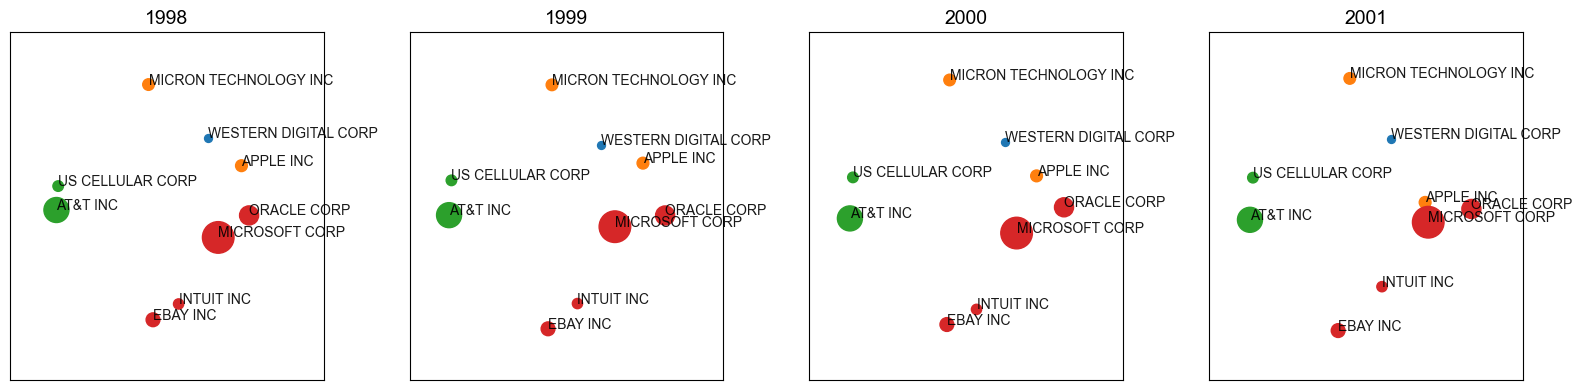

In [50]:
from evomap.printer import draw_map_sequence
fig = draw_map_sequence(X_t[:4], 
                  color = sic_codes,
                  label = labels, 
                  size = sizes,
                  fig_size = (16,4),
                  n_cols = 4,
                  time_labels = periods[:4])

fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_sequence.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_sequence.svg'), dpi = 1200)

fig

### Advanced: Adjust Figure Layout

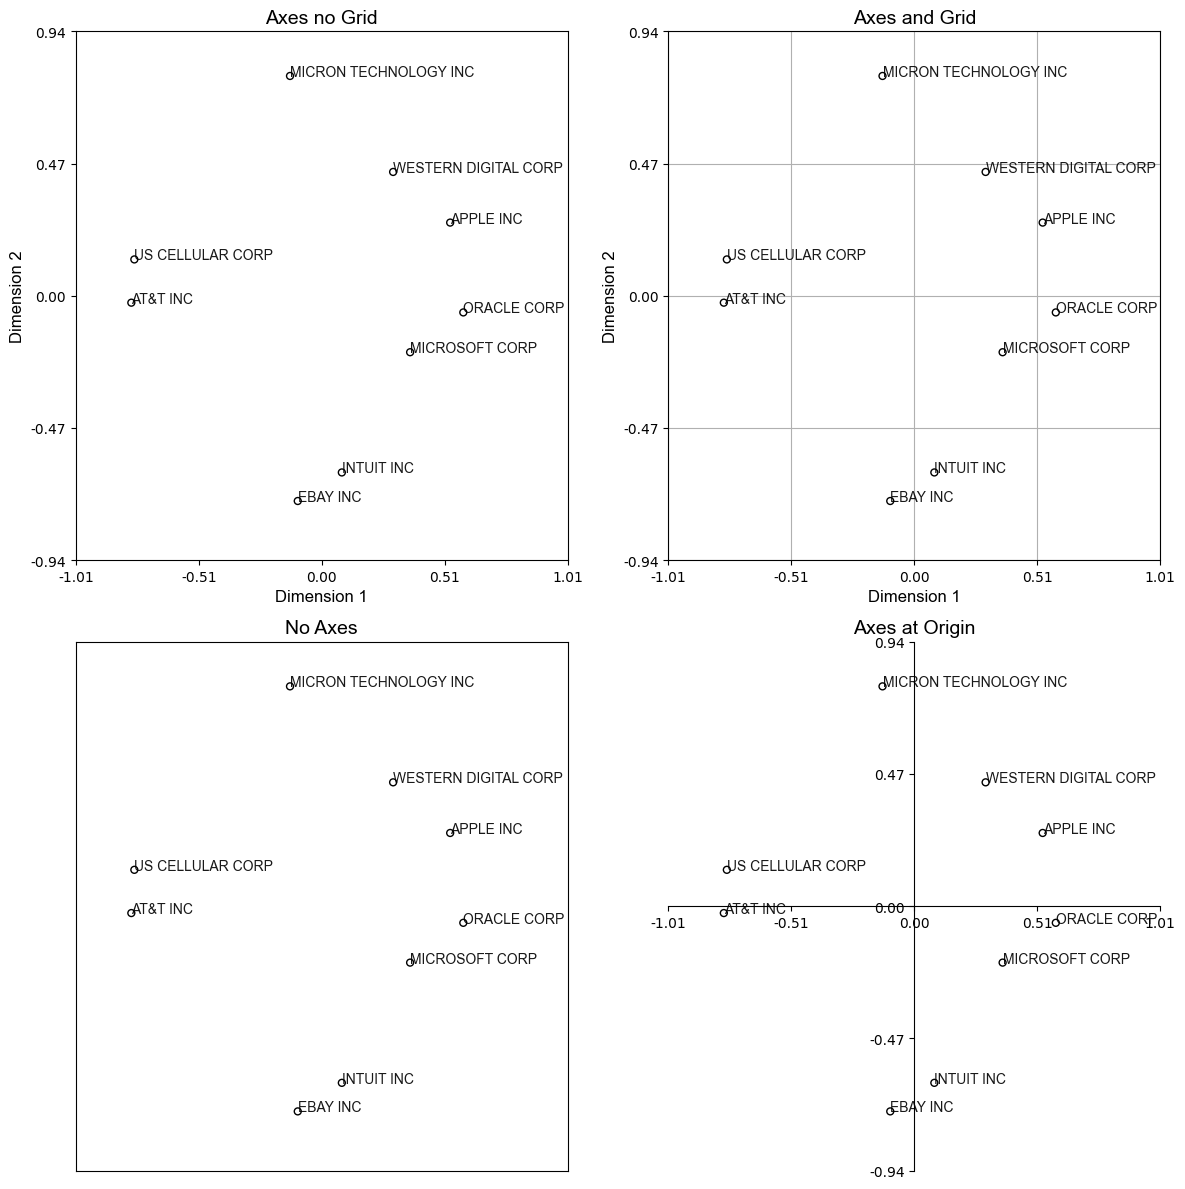

In [51]:
fig, ax = plt.subplots(2,2, figsize = (12,12))
draw_map(X_t[0], label = labels, show_axes = True, axes_at_origin = False, show_grid = False, ax = ax[0,0], title = 'Axes no Grid')
draw_map(X_t[0], label = labels, show_axes = True, axes_at_origin = False, show_grid = True, ax = ax[0,1], title = 'Axes and Grid')
draw_map(X_t[0], label = labels, show_axes = False, axes_at_origin = False, show_grid = False, ax = ax[1,0], title = 'No Axes')
draw_map(X_t[0], label = labels, show_axes = True, axes_at_origin = True, show_grid = False, ax = ax[1,1], title = 'Axes at Origin')
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_options.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect4_draw_map_options.svg'), dpi = 1200)
fig

## Drawing Dynamic Maps

### Dynamic Map

In [52]:
sic_codes_t = []
sizes_t = []
for t in range(n_periods):
    # get data in period t
    data_this = data.query('year == @periods[@t]')
    # get all sic codes in period t
    sic_this = []
    for firm in labels:
        sic_this.append(data_this.query('name1 == @firm').sic1.unique()[0])

    sic_codes_t.append(np.array(sic_this))    

    sizes_this = []
    for firm in labels:
        sizes_this.append(data_this.query('name1 == @firm').size1.unique()[0])
    
    sizes_t.append(np.array(sizes_this))


In [53]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

from evomap.printer import draw_dynamic_map
draw_dynamic_map(X_t,
                 label = labels,
                 color_t = sic_codes_t,
                 size_t = sizes_t,
                 show_arrows = True,
                 title = 'A: Dynamic Map',
                 ax = ax[0])

### Draw Trajectories

In [54]:
from evomap.printer import draw_trajectories
draw_trajectories(X_t, 
                  labels = labels, 
                  period_labels = periods, 
                  title = "B: Trajectories", 
                  ax = ax[1])

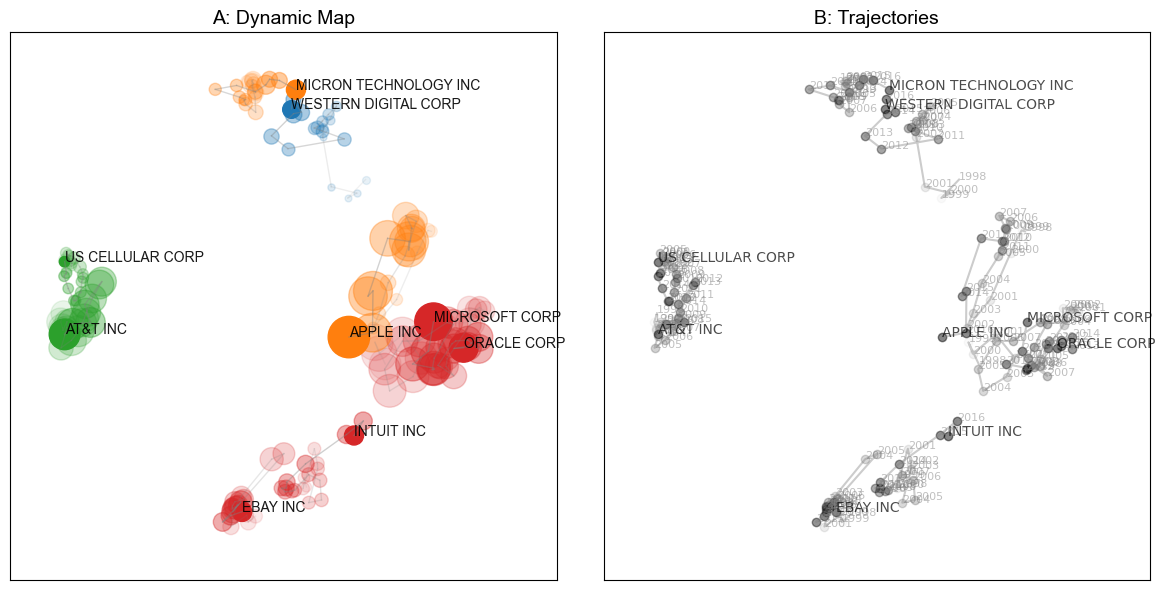

In [55]:
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect4_dynamic_map_and_trajectories.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect4_dynamic_map_and_trajectories.svg'), dpi = 1200)

fig

In [56]:
evomds = EvoMDS(alpha = .2, p = 2, mds_type = 'ordinal', init = cmds_t)
X_t = evomds.fit_transform(D_t) 

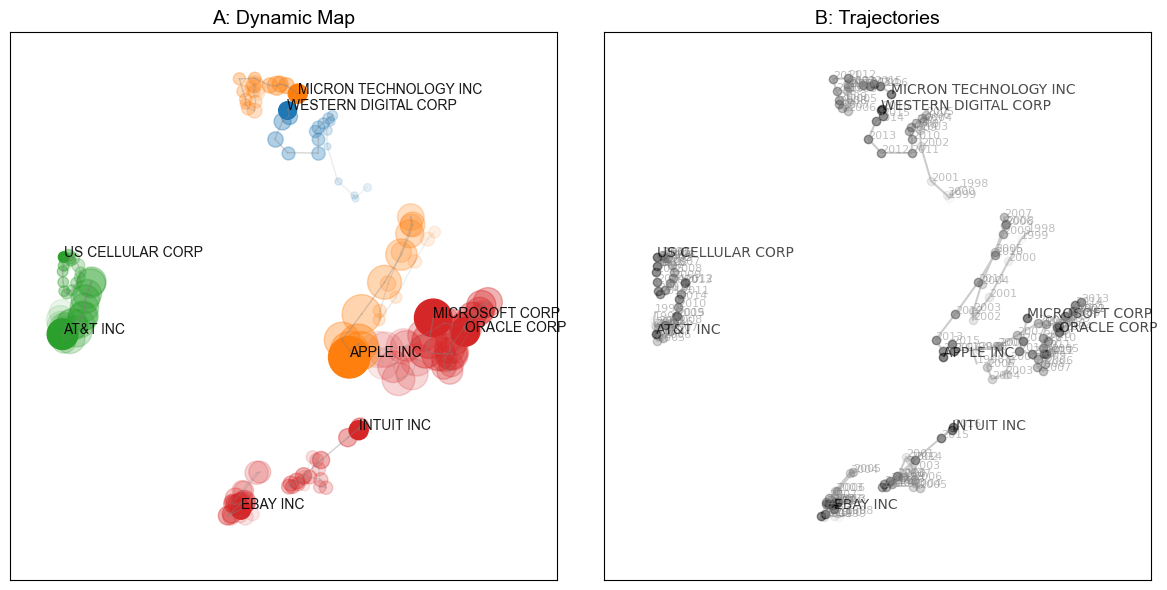

In [57]:
fig, ax = plt.subplots(1,2, figsize = (12,6))

draw_dynamic_map(X_t,
                 label = labels,
                 color_t = sic_codes_t,
                 size_t = sizes_t,
                 show_arrows = True,
                 title = 'A: Dynamic Map',
                 ax = ax[0])

draw_trajectories(X_t, 
                  labels = labels, 
                  period_labels = periods, 
                  title = "B: Trajectories", 
                  ax = ax[1])

fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect4_dynamic_map_and_trajectories_p2.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect4_dynamic_map_and_trajectories_p2.svg'), dpi = 1200)

fig

## Evaluation

### Cost Function Values

In [58]:
evomds_indep = EvoMDS(alpha = 0, verbose = 2, init = cmds_t, mds_type= 'ordinal').fit(D_t)

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 3.61 -- Gradient Norm: 0.0172
[EvoMDS] Iteration 100 -- Cost: 3.61 -- Gradient Norm: 0.0058
[EvoMDS] Iteration 149: gradient norm vanished. Final cost: 3.60


In [59]:
print(evomds_indep.cost_static_avg_.round(3))

0.18


In [60]:
print(evomds.cost_static_avg_.round(3))

0.191


### Evaluation Metrics

In [61]:
from evomap.metrics import *

misalign_score_t = []
persistence_score_t = []
avg_hitrate_score_t = []

for i, X in enumerate([X_t, X_t_indep, X_t_indep_aligned]):
    misalign_score_t.append(misalign_score(X))
    persistence_score_t.append(persistence_score(X))
    avg_hitrate_score_t.append(avg_hitrate_score(X, D_t, input_format='dissimilarity', n_neighbors=4))
  
metrics = pd.DataFrame({'misalign_score': misalign_score_t, 
                        'persistence_score': persistence_score_t,
                        'hitrate_score': avg_hitrate_score_t},
                          index = ['EvoMDS', 'Independent MDS', 'Independent MDS + Alignment'])

metrics['average_stress'] = [evomds_cmds.cost_static_avg_, evomds_indep.cost_static_avg_, evomds_indep.cost_static_avg_]

# sort metrics such that the order is Independent MDS, Independent MDS + Alignment, EvoMDS
metrics = metrics.reindex(['Independent MDS', 'Independent MDS + Alignment', 'EvoMDS'])
metrics.round(4)

,misalign_score,persistence_score,hitrate_score,average_stress
Independent MDS,1.1694,-0.6240,0.6944,0.1802
Independent MDS + Alignment,0.1675,-0.4653,0.7069,0.1802
EvoMDS,0.0497,0.6405,0.7069,0.1877


In [62]:
metrics.round(4).to_excel(os.path.join(PATH_OUT, 'sect4_metrics.xlsx'))

## Hyperparameter Tuning

### Use the Grid Search

First, define the parameter space across which the grid search shall be completed

In [63]:
param_grid = {
    'alpha': np.linspace(0, 1.5, 15), 
    'p': [1,2]}

Next, define the metrics on which each parameter combination is to be evaluated

In [64]:
from evomap.metrics import misalign_score, persistence_score, avg_hitrate_score

metrics = [misalign_score, persistence_score, avg_hitrate_score]
metric_labels = ['Misalignment', 'Persistence', 'Hitrate']

In [65]:
model = EvoMDS(init = cmds_t, mds_type = 'ordinal')

df_grid_results = model.grid_search(
    Xs = D_t, 
    param_grid = param_grid, 
    eval_functions =  metrics,
    eval_labels = metric_labels, 
    kwargs = {"input_format" : 'dissimilarity'})

[EvoMDS] Diverging gradient norm at iteration 206
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 96
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 66
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 52
[EvoMDS] Adjusting step sizes..
[EvoMDS] Diverging gradient norm at iteration 44
[EvoMDS] Adjusting step sizes..


In [66]:
df_grid_results.head()

,p,cost_static_avg,Misalignment,Persistence,Hitrate
alpha,,,,,
0.000000,1,0.180193,0.166333,-0.462381,0.9
0.000000,2,0.180193,0.166333,-0.462381,0.9
0.107143,1,0.184926,0.084685,0.024701,0.9
0.107143,2,0.189348,0.059707,0.504586,0.9
0.214286,1,0.188030,0.064083,0.209860,0.9


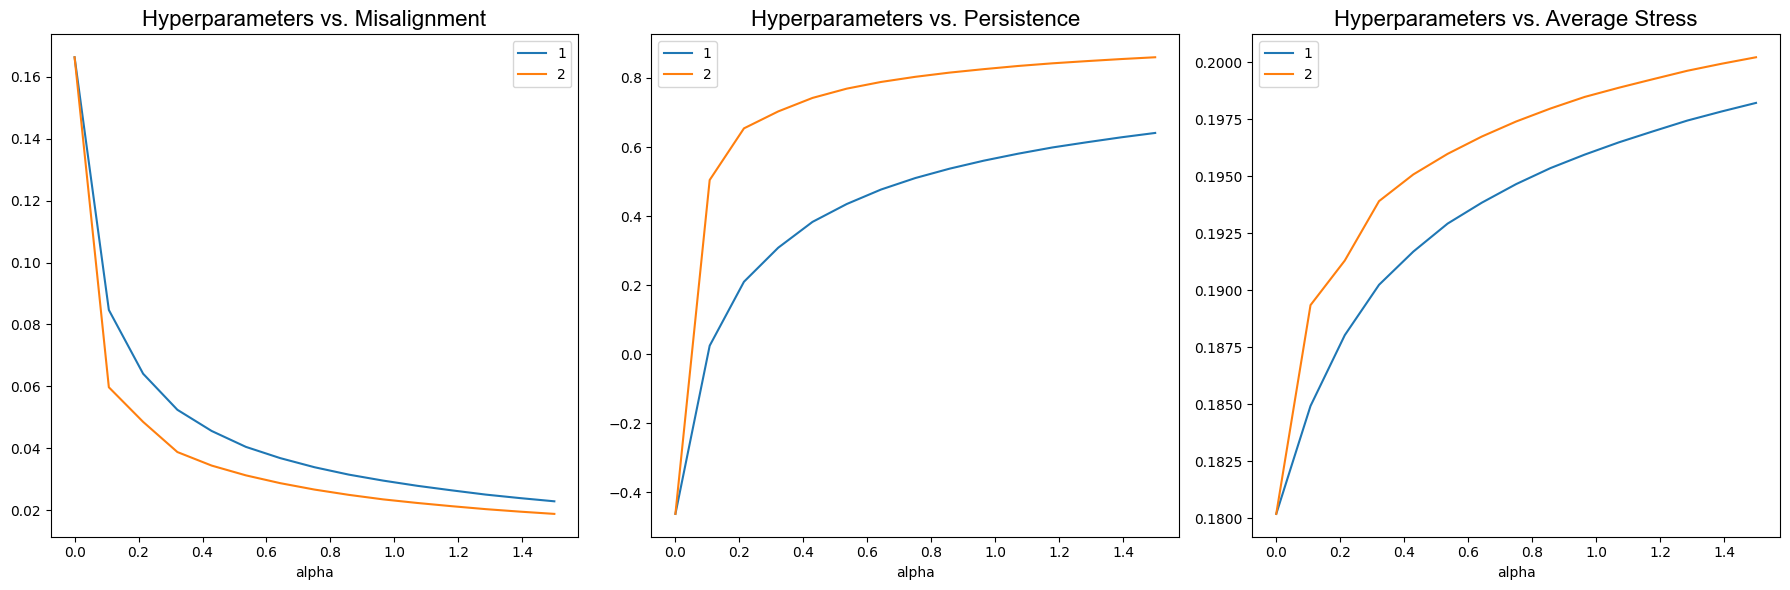

In [67]:
fig, ax = plt.subplots(1,3, figsize = (18, 6))
df_grid_results.groupby('p')['Misalignment'].plot(legend = True, ax = ax[0])
df_grid_results.groupby('p')['Persistence'].plot(legend = True, ax = ax[1])
df_grid_results.groupby('p')['cost_static_avg'].plot(legend = True, ax = ax[2])

ax[0].set_title('Hyperparameters vs. Misalignment', fontdict = title_fontdict_large)
ax[1].set_title('Hyperparameters vs. Persistence', fontdict = title_fontdict_large)
ax[2].set_title('Hyperparameters vs. Average Stress', fontdict = title_fontdict_large)

fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect5_grid_search.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect5_grid_search.svg'), dpi = 1200)

### Results across Hyperparameters

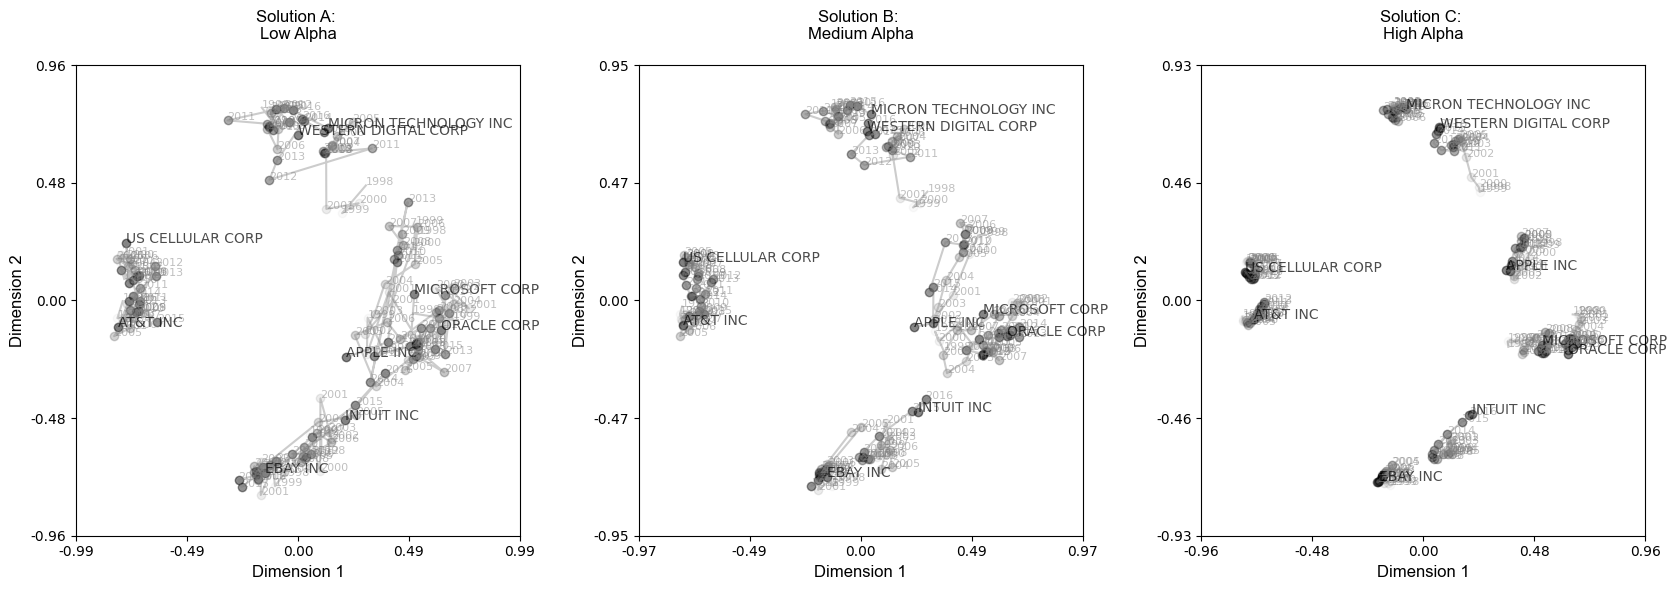

In [68]:
X_t_low_alpha = EvoMDS(alpha = 0.01, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
#X_t_low_alpha = align_maps(X_t_low_alpha, X_t[0])

X_t_mid_alpha = EvoMDS(alpha = 0.2, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
#X_t_mid_alpha = align_maps(X_t_mid_alpha, X_t[0])

X_t_high_alpha = EvoMDS(alpha = 1.5, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)
#X_t_high_alpha = align_maps(X_t_high_alpha, X_t[0])

from evomap.printer import draw_trajectories
fig, ax = plt.subplots(1,3,figsize = (17,6))
draw_trajectories(X_t_low_alpha, show_axes= True, labels = labels, period_labels= periods, ax = ax[0])
draw_trajectories(X_t_mid_alpha, labels = labels, period_labels = periods, show_axes=True, ax = ax[1])
draw_trajectories(X_t_high_alpha, labels = labels, period_labels = periods, show_axes = True, ax = ax[2])
ax[0].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_title('Solution A: \nLow Alpha\n', fontdict = title_fontdict)
ax[1].set_title('Solution B: \nMedium Alpha\n', fontdict = title_fontdict)
ax[2].set_title('Solution C: \nHigh Alpha\n', fontdict = title_fontdict)

ax[1].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[2].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[1].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[2].set_ylabel("Dimension 2", fontdict = title_fontdict)
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect5_hyperparameter_alpha.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect5_hyperparameter_alpha.svg'), dpi = 1200)

fig

### Results across Hyperparameter p

[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 3.80 -- Gradient Norm: 0.0283
[EvoMDS] Iteration 100 -- Cost: 3.80 -- Gradient Norm: 0.0012
[EvoMDS] Iteration 105: gradient norm vanished. Final cost: 3.80
[EvoMDS] Running Gradient Descent with Backtracking via Halving
[EvoMDS] Iteration 50 -- Cost: 3.88 -- Gradient Norm: 0.0134
[EvoMDS] Iteration 100 -- Cost: 3.88 -- Gradient Norm: 0.0051
[EvoMDS] Iteration 150 -- Cost: 3.87 -- Gradient Norm: 0.0059
[EvoMDS] Iteration 200 -- Cost: 3.87 -- Gradient Norm: 0.0054
[EvoMDS] Iteration 250 -- Cost: 3.87 -- Gradient Norm: 0.0064
[EvoMDS] Iteration 300 -- Cost: 3.87 -- Gradient Norm: 0.0028
[EvoMDS] Iteration 350 -- Cost: 3.87 -- Gradient Norm: 0.0058
[EvoMDS] Iteration 400 -- Cost: 3.87 -- Gradient Norm: 0.0065
[EvoMDS] Iteration 450 -- Cost: 3.86 -- Gradient Norm: 0.0060
[EvoMDS] Iteration 499: gradient norm vanished. Final cost: 3.86
[EvoMDS] Running Gradient Descent with Backtracking via Halvin

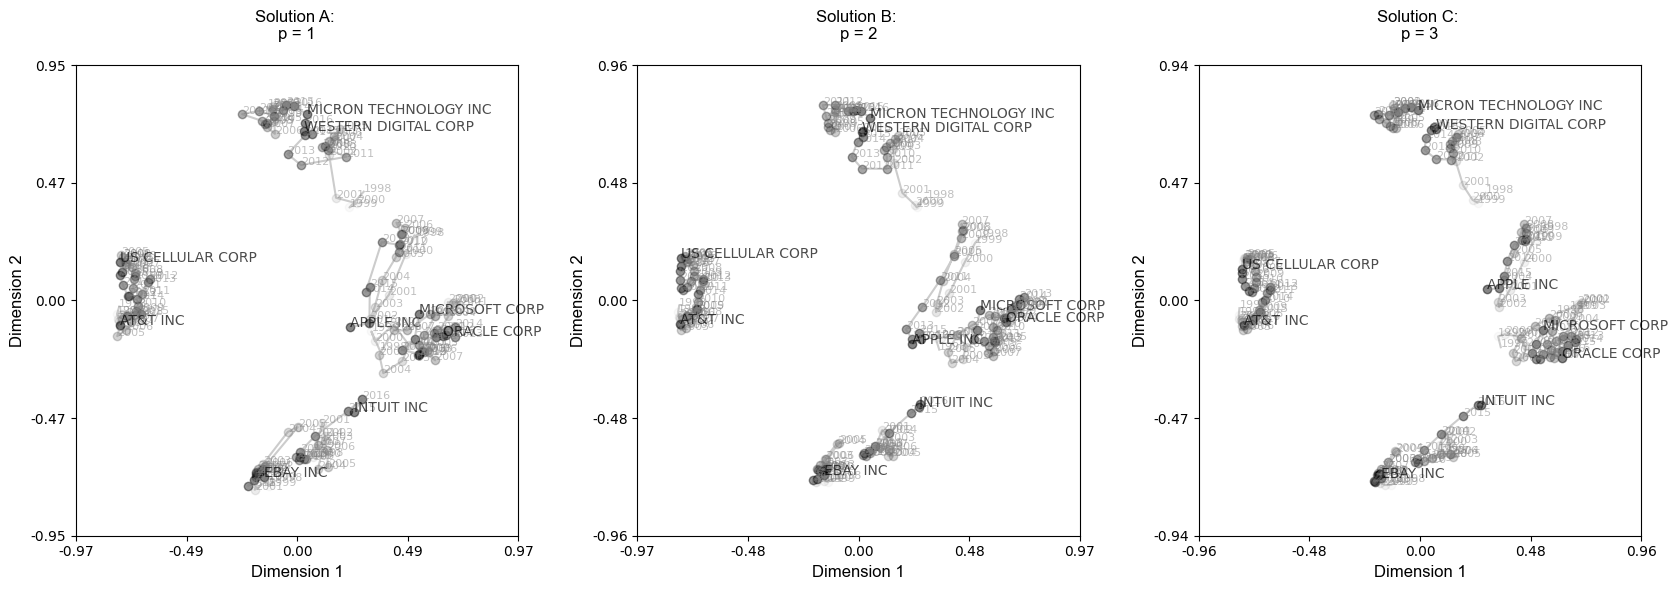

In [69]:
X_t_p1 = EvoMDS(alpha = .2, p = 1, mds_type = 'ordinal', init = cmds_t, verbose = 2).fit_transform(D_t)
X_t_p2 = EvoMDS(alpha = .2, p = 2, mds_type = 'ordinal', init = cmds_t, verbose = 2).fit_transform(D_t)
X_t_p3 = EvoMDS(alpha = .2, p = 3, mds_type = 'ordinal', init = cmds_t, verbose = 2).fit_transform(D_t)

fig, ax = plt.subplots(1,3,figsize = (17,6))
draw_trajectories(X_t_p1, show_axes= True, labels = labels, period_labels= periods, ax = ax[0])
draw_trajectories(X_t_p2, labels = labels, period_labels = periods, show_axes=True, ax = ax[1])
draw_trajectories(X_t_p3, labels = labels, period_labels = periods, show_axes = True, ax = ax[2])
ax[0].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_title('Solution A: \np = 1\n', fontdict = title_fontdict)
ax[1].set_title('Solution B: \np = 2\n', fontdict = title_fontdict)
ax[2].set_title('Solution C: \np = 3\n', fontdict = title_fontdict)

ax[1].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[2].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[1].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[2].set_ylabel("Dimension 2", fontdict = title_fontdict)
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect5_hyperparameter_p.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect5_hyperparameter_p.svg'), dpi = 1200)
fig

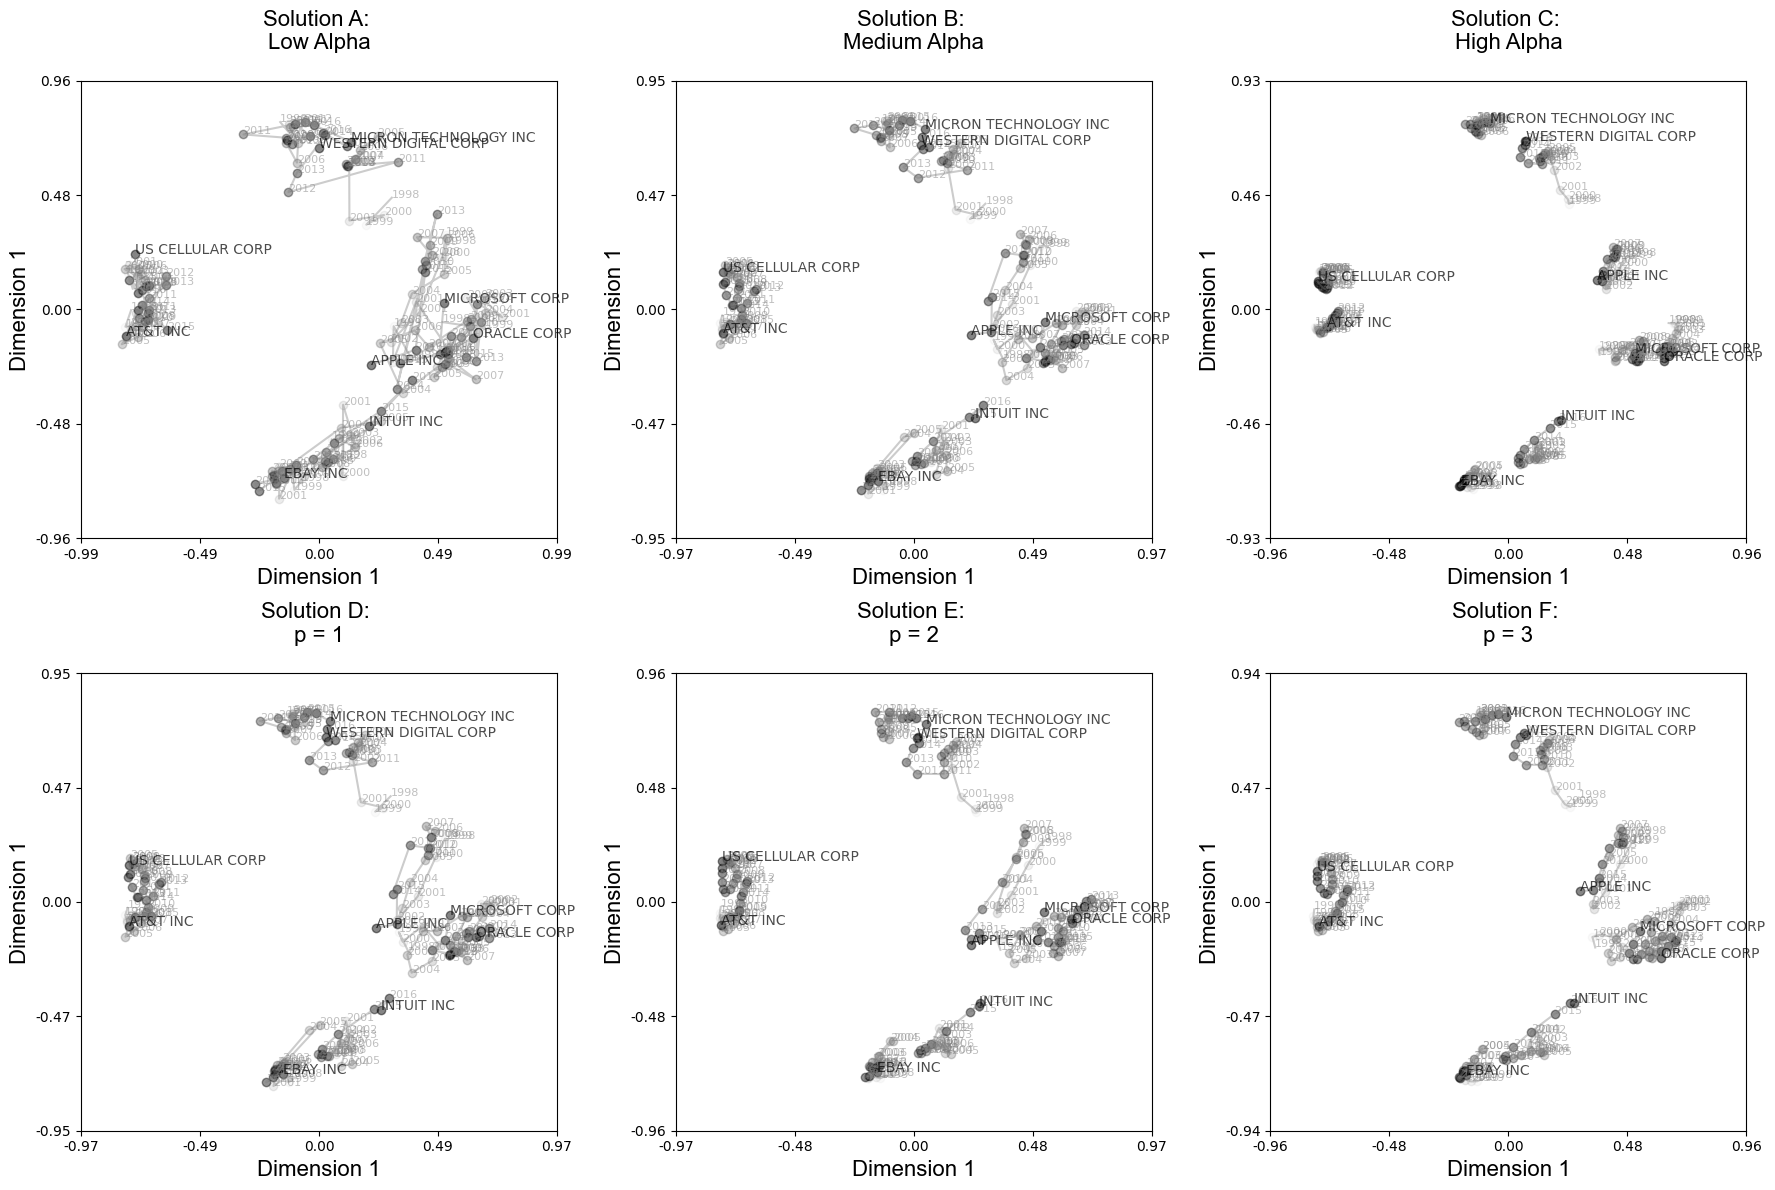

In [70]:
fig, ax = plt.subplots(2,3,figsize = (18,12))

draw_trajectories(X_t_low_alpha, show_axes= True, labels = labels, period_labels= periods, ax = ax[0,0])
draw_trajectories(X_t_mid_alpha, labels = labels, period_labels = periods, show_axes=True, ax = ax[0,1])
draw_trajectories(X_t_high_alpha, labels = labels, period_labels = periods, show_axes = True, ax = ax[0,2])

draw_trajectories(X_t_p1, show_axes= True, labels = labels, period_labels= periods, ax = ax[1,0])
draw_trajectories(X_t_p2, labels = labels, period_labels = periods, show_axes=True, ax = ax[1,1])
draw_trajectories(X_t_p3, labels = labels, period_labels = periods, show_axes = True, ax = ax[1,2])

ax[0,0].set_title('Solution A: \nLow Alpha\n', fontdict = title_fontdict_large)
ax[0,1].set_title('Solution B: \nMedium Alpha\n', fontdict = title_fontdict_large)
ax[0,2].set_title('Solution C: \nHigh Alpha\n', fontdict = title_fontdict_large)
ax[1,0].set_title('Solution D: \np = 1\n', fontdict = title_fontdict_large)
ax[1,1].set_title('Solution E: \np = 2\n', fontdict = title_fontdict_large)
ax[1,2].set_title('Solution F: \np = 3\n', fontdict = title_fontdict_large)

ax[0,0].set_xlabel('Dimension 1', fontdict = title_fontdict_large)
ax[0,1].set_xlabel('Dimension 1', fontdict = title_fontdict_large)
ax[0,2].set_xlabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,0].set_xlabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,1].set_xlabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,2].set_xlabel('Dimension 1', fontdict = title_fontdict_large)

ax[0,0].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
ax[0,1].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
ax[0,2].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,0].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,1].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
ax[1,2].set_ylabel('Dimension 1', fontdict = title_fontdict_large)
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect5_hyperparamters.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect5_hyperparamters.svg'), dpi = 1200)

fig

### Results across MDS Types

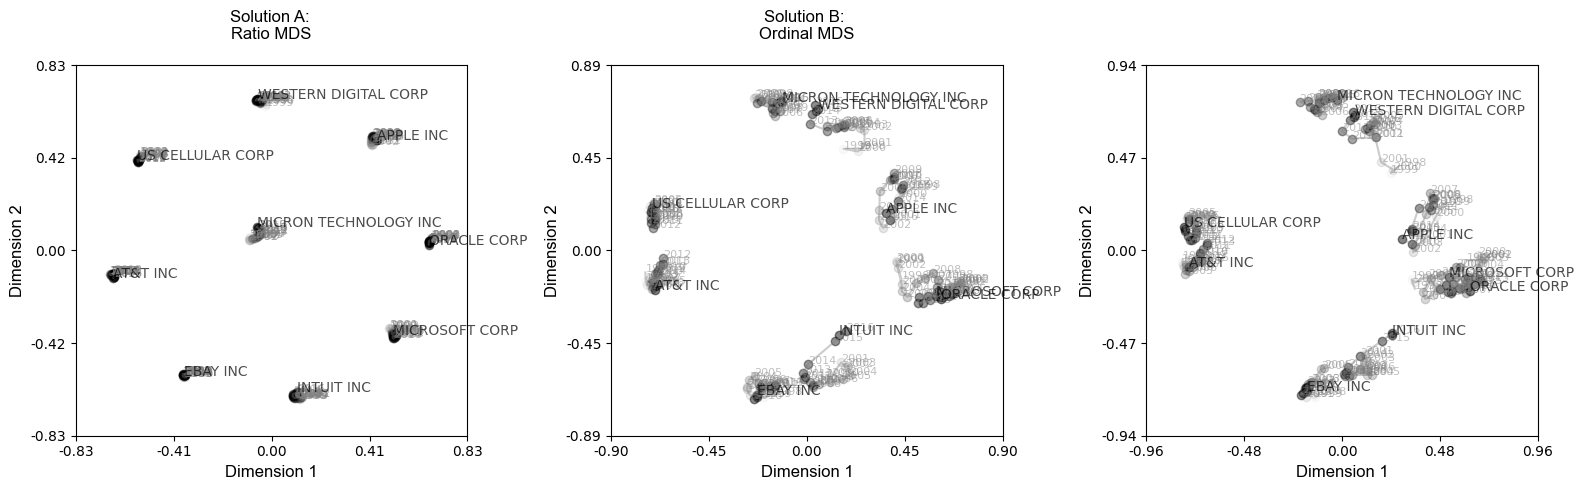

In [71]:
X_t_ratio = EvoMDS(alpha = .5, p = 1, mds_type = 'ratio', init = cmds_t).fit_transform(D_t)
X_t_interval = EvoMDS(alpha = .5, p = 1, mds_type = 'interval', init = cmds_t).fit_transform(D_t)
X_t_ordinal = EvoMDS(alpha = .5, p = 1, mds_type = 'ordinal', init = cmds_t).fit_transform(D_t)

fig, ax = plt.subplots(1,3,figsize = (16,5))
draw_trajectories(X_t_ratio, labels = labels, period_labels = periods, show_axes=True, ax = ax[0])
draw_trajectories(X_t_interval, labels = labels, period_labels = periods, show_axes=True, ax = ax[1])
draw_trajectories(X_t_ordinal, labels = labels, period_labels = periods, show_axes = True, ax = ax[2])
ax[0].set_title('Solution A: \nRatio MDS\n', fontdict = title_fontdict)
ax[1].set_title('Solution B: \nInterval MDS\n', fontdict = title_fontdict)
ax[1].set_title('Solution B: \nOrdinal MDS\n', fontdict = title_fontdict)

ax[0].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[1].set_xlabel("Dimension 1", fontdict = title_fontdict)
ax[0].set_ylabel("Dimension 2", fontdict = title_fontdict)
ax[1].set_ylabel("Dimension 2", fontdict = title_fontdict)

fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect5_mds_types.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect5_mds_types.svg'), dpi = 1200)
fig

## Unbalanced Data

In [72]:
data_unbalanced = load_tnic_sample_tech(unbalanced = True)
data_unbalanced.groupby('name1').agg({'year': 'nunique'})

,year
name1,
APPLE INC,20
AT&T INC,20
EBAY INC,20
INTUIT INC,20
MICRON TECHNOLOGY INC,20
MICROSOFT CORP,20
NETFLIX INC,16
ORACLE CORP,20
US CELLULAR CORP,20


In [73]:
from evomap.preprocessing import edgelist2matrices
S_t, labels = edgelist2matrices(
    data_unbalanced, 
    score_var='score', 
    id_var_i='name1', 
    id_var_j='name2', 
    time_var = 'year')

In [74]:
print(S_t[0].shape)
print(S_t[-1].shape)

(9, 9)
(10, 10)


In [75]:
from evomap.preprocessing import expand_matrices
S_t, inc_t, labels = expand_matrices(S_t, labels)

In [76]:
print(S_t[0].shape)

(10, 10)


In [77]:
print(inc_t[0])

[1 1 1 1 1 1 1 1 1 0]


In [78]:
inc_t[-1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [79]:
D_t = []
for S in S_t:
    D = sim2diss(S)
    D_t.append(D)

In [80]:
from evomap.mapping import EvoMDS
X_t = EvoMDS(alpha = .2, p = 2,  mds_type = 'ordinal').fit_transform(D_t, inclusions = inc_t)

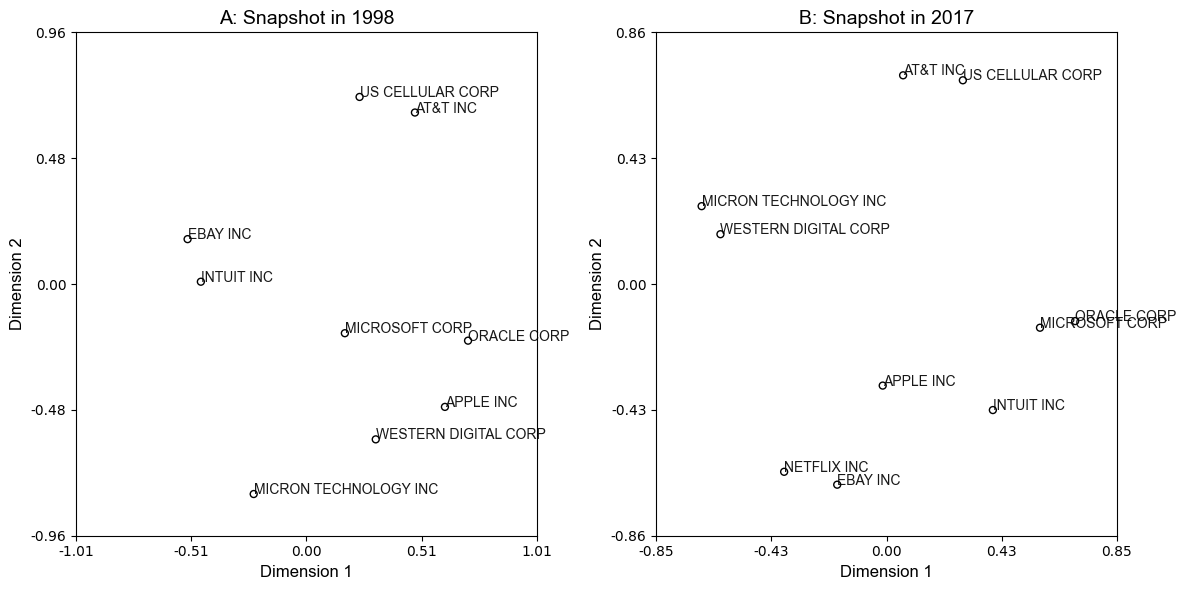

In [81]:
from matplotlib import pyplot as plt   
from evomap.printer import draw_map 
fig, ax = plt.subplots(1,2,figsize=(12, 6))
draw_map(X_t[0], inclusions = inc_t[0], label = labels, ax = ax[0], show_axes=True, title = 'A: Snapshot in {0}'.format(periods[0]))
draw_map(X_t[-1], inclusions = inc_t[-1], label = labels, ax = ax[1], show_axes = True, title = 'B: Snapshot in {0}'.format(periods[-1])) 
fig.tight_layout()
fig.savefig(os.path.join(PATH_OUT, 'sect5_unbalanced.PNG'), dpi = 1200)
fig.savefig(os.path.join(PATH_OUT, 'sect5_unbalanced.svg'), dpi = 1200)
fig

# THE END

For further examples, using a larger dataset, see https://evomap.readthedocs.io/en/latest/dynamic%20mapping.html